In [1]:
set.seed(123)
getwd()
setwd("/liulab/galib/mm_dlbcl_manuscript/")
library(rBCS)
library(tidyverse)
library(Seurat)
library(harmony)
library(viridis)
library(RColorBrewer)
library(Polychrome)
PurpleAndYellow()
library(ComplexHeatmap)
library(devtools)
library(presto)
library(dplyr)
library(ggplot2)
library(ggpubr)
library(readxl)
source("./scripts/scplot.R")
library(here)

[1] "/liulab/galib/mm_dlbcl_manuscript/scripts"

Warning message:
“package ‘rBCS’ was built under R version 4.1.3”
Warning message:
“package ‘tidyverse’ was built under R version 4.1.3”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.0      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.1 

Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”
Warning message:
“package ‘forcats’ was built under R version 4.1.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching SeuratObject

Attaching sp

Warning message:
“package ‘harmony’ was built under R version 4.1.3”
Loading required package: Rcpp

Warning message:
“package ‘Rcpp’ was built under R version 4.1.2”
Loading required package: viridisLite

Warning message:
“pack

[1] "#FF00FF" "#F400F4" "#EA00EA" "#DF00DF" "#D500D5" "#CA00CA" "#BF00BF"
 [8] "#B500B5" "#AA00AA" "#9F009F" "#950095" "#8A008A" "#800080" "#750075"
[15] "#6A006A" "#600060" "#550055" "#4A004A" "#400040" "#350035" "#2B002B"
[22] "#200020" "#150015" "#0B000B" "#000000" "#000000" "#0B0B00" "#151500"
[29] "#202000" "#2B2B00" "#353500" "#404000" "#4A4A00" "#555500" "#606000"
[36] "#6A6A00" "#757500" "#808000" "#8A8A00" "#959500" "#9F9F00" "#AAAA00"
[43] "#B5B500" "#BFBF00" "#CACA00" "#D4D400" "#DFDF00" "#EAEA00" "#F4F400"
[50] "#FFFF00"

Warning message:
“package ‘ComplexHeatmap’ was built under R version 4.1.3”
Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Loading required package: usethis

Warning message:
“package ‘presto’ was built under R version 4.1.3”
Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The

In [2]:
B_cell<- readRDS("./data/objects/B_cell_final.rds")

In [181]:
trust4_out<- read_tsv( "./data/trust4_combined_barcoderep_filter.tsv", 
                      col_names = FALSE)  %>% select(X1:X3)

trust4<- trust4_out  %>% 
    filter(X3 != "*") %>% separate(col = X3, sep = ",", into = c(rep(NA, 4), "cdr3nt", "cdr3aa" ))  %>% 
    rename("barcode" = X1, "celltype" = X2)

meta<- B_cell@meta.data  %>% mutate(barcode = rownames(B_cell@meta.data)) %>% 
            select(sample_id, seurat_clusters, barcode)

cellType = c("B")

trust4_meta<- trust4  %>% filter(celltype %in% cellType)  %>% left_join(x = meta, by = "barcode")  %>% 
                filter(!is.na(cdr3aa)) 

trust4_meta  %>% dim()

B_cell@meta.data$barcode<- rownames(B_cell@meta.data)


clone <- trust4_meta  %>% 
    add_count(sample_id, name = "total_clone_sample")  %>% 
    add_count(sample_id, cdr3aa, name = "cdr3aa_clone_per_sample")  %>%
    add_count(sample_id, seurat_clusters, cdr3aa, name = "cdr3aa_clone_per_sample_per_cluster")  %>%
    mutate(p_clone_sample = cdr3aa_clone_per_sample/total_clone_sample )  %>% 
    mutate(clone_class = case_when(
        p_clone_sample == 1/total_clone_sample ~ "singleton",
        p_clone_sample < 0.1 ~ "<10%",
        p_clone_sample <= 0.25 ~ "10-25%",
        p_clone_sample <= 0.5 ~ "25-50%",
        TRUE ~ ">50%"))

count <- trust4_meta  %>% count(sample_id, seurat_clusters, name = "count")

# supported by at least 3 cells with cdr for a sample in a cluster to be considered
richness<- trust4_meta  %>% 
    count(seurat_clusters, sample_id, cdr3aa, name = "clone")  %>% 
    left_join(count, by = c("sample_id", "seurat_clusters"))  %>% 
    filter(count >=3)  %>%
    count(seurat_clusters, sample_id, name = 'richness')

entropy<- trust4_meta  %>% 
    count(sample_id, seurat_clusters, cdr3aa, name = "clone")  %>%
    left_join(y = count, by = c("sample_id", "seurat_clusters"))  %>%
    filter(count >=3)  %>%
    mutate(freq = clone/count)  %>%
    mutate(log_freq  = log(freq))  %>%
    group_by(seurat_clusters, sample_id)  %>% 
    summarise(entropy = sum(-freq*log_freq))

tcr_df<- 
    inner_join(richness, entropy)  %>% 
    mutate(clonality_trust4 = 1 - (entropy/log(richness)))

tcr_df[(tcr_df$richness == 1 & tcr_df$entropy == 0), 'clonality_trust4'] = 1

B_cell_trust4<- left_join(B_cell@meta.data, tcr_df, by = c("seurat_clusters", "sample_id"))  %>% 
                        left_join(y = clone, by = c("barcode", "seurat_clusters", "sample_id"))
B_cell_trust4  %>% dim()
B_cell_trust4$UMAP_1<- B_cell@reductions$umap@cell.embeddings[,1]
B_cell_trust4$UMAP_2<- B_cell@reductions$umap@cell.embeddings[,2]

write_tsv(x = B_cell_trust4, file = "./data/B_cell_metadata_trust4_results.tsv", col_names = TRUE)

Rows: 264343 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): X1, X2, X3, X4, X5, X6

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Expected 6 pieces. Additional pieces discarded in 122861 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


[1] 58676     6

`summarise()` has grouped output by 'seurat_clusters'. You can override using
the `.groups` argument.
Joining, by = c("seurat_clusters", "sample_id")


[1] 176583     39

## calculate median by genotype x cluster 

In [183]:
#Calculate median per cluster per genotype
clonality_median_per_cluster_per_genotype<- B_cell_trust4  %>% 
    distinct(new_annotation, sample_id, clonality_trust4, genotype)  %>% 
    group_by(new_annotation, genotype)  %>% 
    summarize(clonality_median_per_cluster_per_genotype = median(clonality_trust4, na.rm = TRUE))

clonality_median_meta<- left_join(B_cell_trust4, clonality_median_per_cluster_per_genotype)
B_cell_trust4$clonality_median_per_cluster_per_genotype <- clonality_median_meta$clonality_median_per_cluster_per_genotype

entropy_median_per_cluster_per_genotype<- B_cell_trust4  %>% distinct(new_annotation, sample_id, entropy, genotype)  %>% 
    group_by(new_annotation, genotype)  %>% 
    summarize(entropy_median_per_cluster_per_genotype = median(entropy, na.rm = TRUE))

entropy_median_meta<- left_join(B_cell_trust4, entropy_median_per_cluster_per_genotype)
B_cell_trust4$entropy_median_per_cluster_per_genotype <- entropy_median_meta$entropy_median_per_cluster_per_genotype

richness_median_per_cluster_per_genotype<- B_cell_trust4  %>% distinct(new_annotation, sample_id, richness, genotype)  %>% 
    group_by(new_annotation, genotype)  %>% 
    summarize(richness_median_per_cluster_per_genotype = median(richness, na.rm = TRUE))

richness_median_meta<- left_join(B_cell_trust4, richness_median_per_cluster_per_genotype)
B_cell_trust4$richness_median_per_cluster_per_genotype <- richness_median_meta$richness_median_per_cluster_per_genotype

`summarise()` has grouped output by 'new_annotation'. You can override using
the `.groups` argument.
Joining, by = c("genotype", "new_annotation")
`summarise()` has grouped output by 'new_annotation'. You can override using
the `.groups` argument.
Joining, by = c("genotype", "new_annotation")
`summarise()` has grouped output by 'new_annotation'. You can override using
the `.groups` argument.
Joining, by = c("genotype", "new_annotation")


In [184]:
# export median into tsv files
write.table(x = clonality_median_per_cluster_per_genotype, file = './data/B_cell_clonality_median_per_cluster_per_genotype.tsv', quote = FALSE,sep = '\t', row.names = F, col.names = T)
write.table(x = entropy_median_per_cluster_per_genotype, file = './data/B_cell_entropy_median_per_cluster_per_genotype.tsv', quote = FALSE,sep = '\t', row.names = F, col.names = T)
write.table(x = richness_median_per_cluster_per_genotype, file = './data/B_cell_richness_median_per_cluster_per_genotype.tsv', quote = FALSE,sep = '\t', row.names = F, col.names = T)

WT

CD70

Bcl6tg

CD70_Bcl6tg



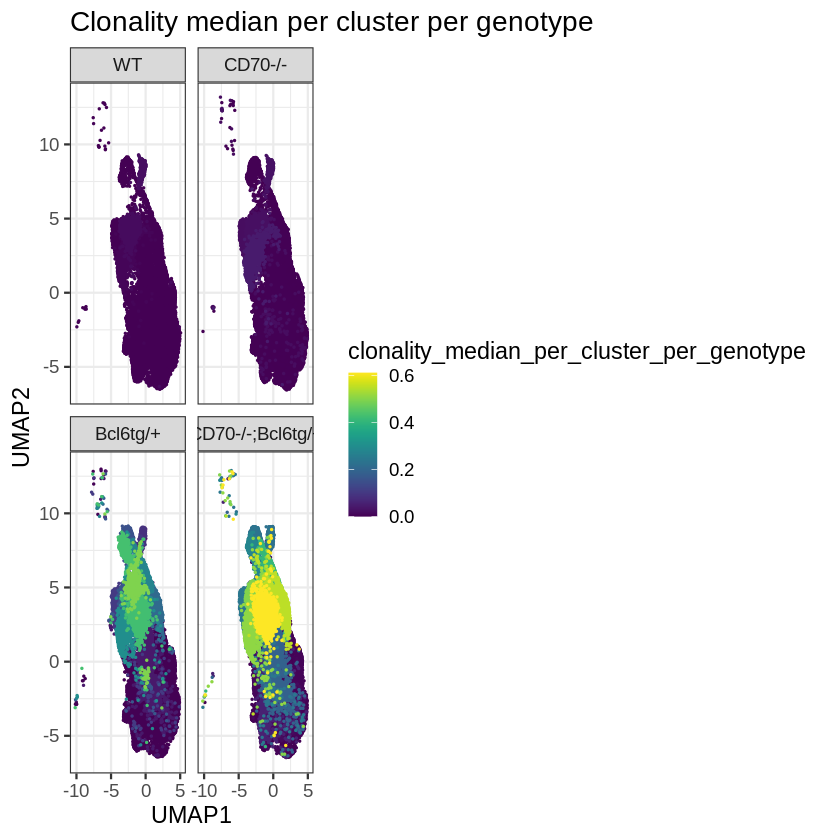

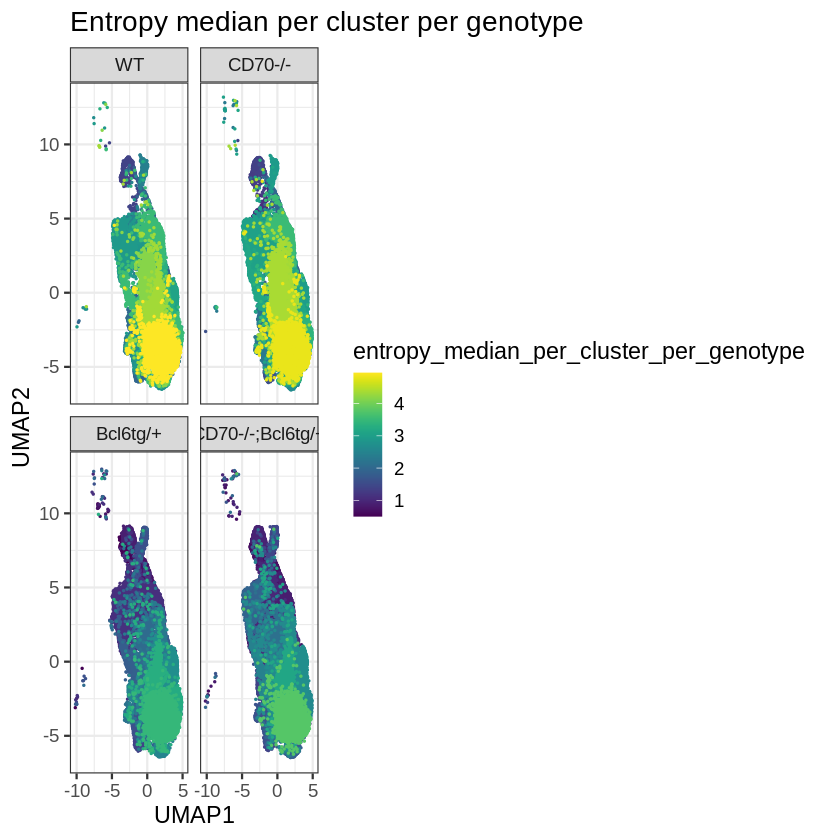

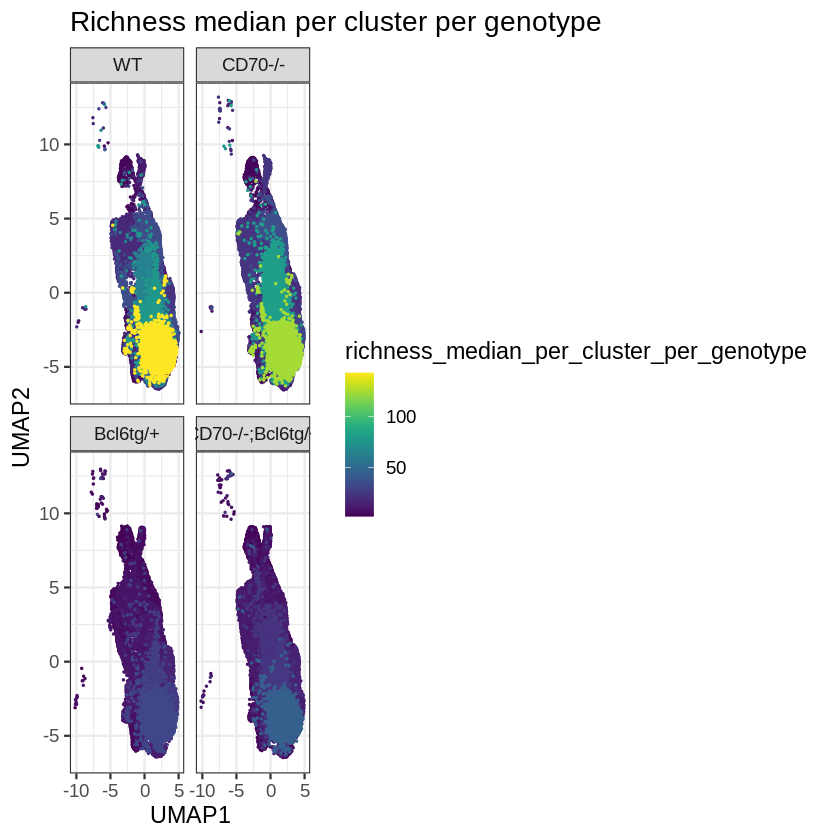

In [185]:
#Clonality
for (gt in c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")){
    
    gtype  = gsub(gt, pattern = '/[-+]', replacement = "")  %>% 
            gsub(pattern = ';', replacement = "_")  %>% 
            gsub(pattern = '-', replacement = "")

    message(gtype)
    
    B_cell_trust4 %>%
        filter(genotype == gt)  %>%
        mutate(is_na= !is.na(clonality_median_per_cluster_per_genotype))  %>% 
        arrange(is_na, clonality_median_per_cluster_per_genotype)  %>%
        mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
        ggplot(aes(x = UMAP_1, y= UMAP_2)) +
        geom_point(aes(color = clonality_median_per_cluster_per_genotype), size = 0.3) +
        scale_color_viridis(discrete = FALSE) +
        theme_bw(base_size = 14) +
        labs(x = "UMAP1", y = "UMAP2", title = "Median of Clonality Per Cluster")

    ggsave(paste0("./results/figures/7_B_cell_clonality_median_per_cluster_", gtype ,".pdf"), width = 9, height =6)

    #Entropy

    B_cell_trust4 %>%
        filter(genotype == gt)  %>%
        mutate(is_na= !is.na(entropy_median_per_cluster_per_genotype))  %>% 
        arrange(is_na, entropy_median_per_cluster_per_genotype)  %>%
        mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
        ggplot(aes(x = UMAP_1, y= UMAP_2)) +
        geom_point(aes(color = entropy_median_per_cluster_per_genotype), size = 0.3) +
        scale_color_viridis(discrete = FALSE) +
        theme_bw(base_size = 14) +
        labs(x = "UMAP1", y = "UMAP2", title = "Median of Entropy Per Cluster") 

    ggsave(paste0("./results/figures/7_B_cell_entropy_median_per_cluster_", gtype ,".pdf"), width = 9, height =6)


    #richness

    B_cell_trust4 %>%
        filter(genotype == gt)  %>%
        mutate(is_na= !is.na(richness_median_per_cluster_per_genotype))  %>% 
        arrange(is_na, richness_median_per_cluster_per_genotype)  %>%
        mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
        mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
        ggplot(aes(x = UMAP_1, y= UMAP_2)) +
        geom_point(aes(color = richness_median_per_cluster_per_genotype), size = 0.3) +
        scale_color_viridis(discrete = FALSE) +
        theme_bw(base_size = 14) +
        labs(x = "UMAP1", y = "UMAP2", title = "Median of Richness Per Cluster") 

    ggsave(paste0("./results/figures/7_B_cell_richness_median_per_cluster_", gtype ,".pdf"), width = 9, height =6)

}

B_cell_trust4 %>%
    mutate(is_na= !is.na(clonality_median_per_cluster_per_genotype))  %>% 
    arrange(is_na, clonality_median_per_cluster_per_genotype)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))   %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = clonality_median_per_cluster_per_genotype), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    facet_wrap(~ genotype, ncol = 2) +
    theme_bw(base_size = 14) +
    labs(x = "UMAP1", y = "UMAP2", title = "Clonality median per cluster per genotype") 

ggsave(here("./results/figures/7_B_cell_clonality_median_per_cluster_per_genotype.pdf"), width = 11, height =8)

B_cell_trust4 %>%
    mutate(is_na= !is.na(entropy_median_per_cluster_per_genotype))  %>% 
    arrange(is_na, entropy_median_per_cluster_per_genotype)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = entropy_median_per_cluster_per_genotype), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    facet_wrap(~ genotype, ncol = 2) +
    theme_bw(base_size = 14) +
    labs(x = "UMAP1", y = "UMAP2", title = "Entropy median per cluster per genotype") 

ggsave(here("./results/figures/7_B_cell_entropy_median_per_cluster_per_genotype.pdf"), width = 11, height =8)


B_cell_trust4 %>%
    mutate(is_na= !is.na(richness_median_per_cluster_per_genotype))  %>% 
    arrange(is_na, richness_median_per_cluster_per_genotype)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = richness_median_per_cluster_per_genotype), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    facet_wrap(~ genotype, ncol = 2) +
    theme_bw(base_size = 14) +
    labs(x = "UMAP1", y = "UMAP2", title = "Richness median per cluster per genotype") 

ggsave(here("./results/figures/7_B_cell_richness_median_per_cluster_per_genotype.pdf"), width = 11, height =8)

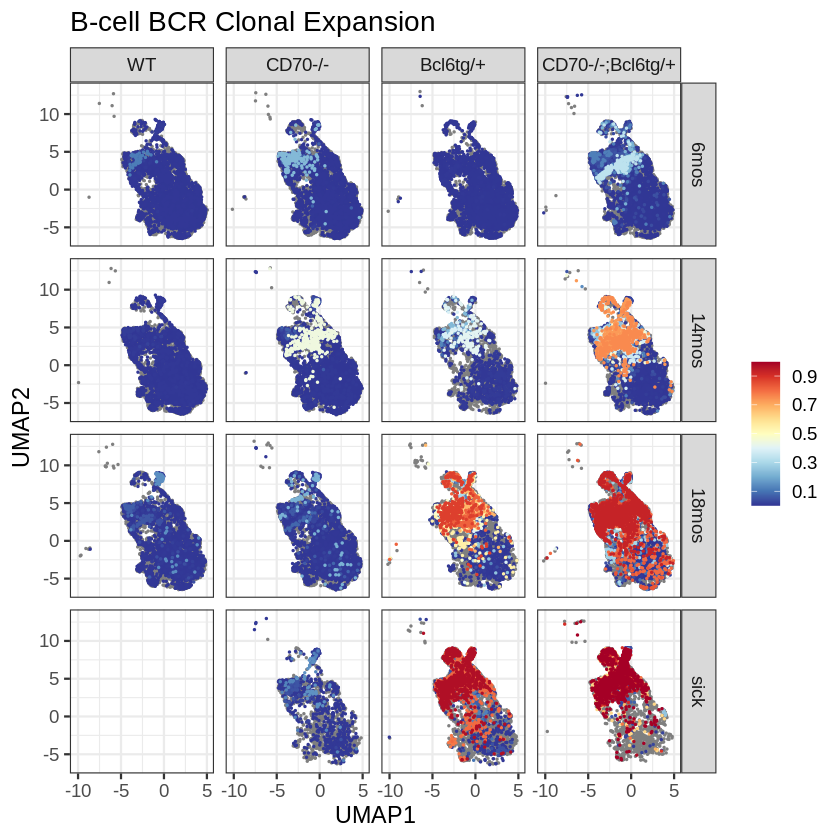

In [186]:
mycol = rev(brewer.pal(11,"RdYlBu"))
B_cell_trust4 %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    mutate(is_na= !is.na(p_clone_sample))  %>% 
    arrange(is_na, p_clone_sample)  %>%
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = p_clone_sample), size = 0.3) +
    scale_color_gradientn(colours = mycol, breaks = c(0.1, 0.3, 0.5, 0.7, 0.9)) +
    theme_bw(base_size = 14) +
    labs(x = "UMAP1", y = "UMAP2", title = "B-cell BCR Clonal Expansion") +
    theme(legend.title=element_blank()) +
    facet_grid(age ~ genotype)

ggsave("./results/figures/7_B_cell_cdr3_clone_percentage_continuous_by_genotype_age.pdf", 
       width = 12, height = 10)

In [187]:
#Calculate mean per cluster
clonality_mean_per_cluster<- B_cell_trust4  %>% distinct(new_annotation, sample_id, clonality_trust4)  %>% 
    group_by(new_annotation)  %>% 
    summarize(clonality_mean = mean(clonality_trust4, na.rm = TRUE))

clonality_mean_meta<- left_join(B_cell_trust4, clonality_mean_per_cluster)
B_cell_trust4$clonality_mean <- clonality_mean_meta$clonality_mean

entropy_mean_per_cluster<- B_cell_trust4  %>% distinct(new_annotation, sample_id, entropy)  %>% 
    group_by(new_annotation)  %>% 
    summarize(entropy_mean = mean(entropy, na.rm = TRUE))

entropy_mean_meta<- left_join(B_cell_trust4, entropy_mean_per_cluster)
B_cell_trust4$entropy_mean <- entropy_mean_meta$entropy_mean

richness_mean_per_cluster<- B_cell_trust4  %>% distinct(new_annotation, sample_id, richness)  %>% 
    group_by(new_annotation)  %>% 
    summarize(richness_mean = mean(richness, na.rm = TRUE))

richness_mean_meta<- left_join(B_cell_trust4, richness_mean_per_cluster)
B_cell_trust4$richness_mean <- richness_mean_meta$richness_mean

#Calculate median per cluster
clonality_median_per_cluster<- B_cell_trust4  %>% distinct(new_annotation, sample_id, clonality_trust4)  %>% 
    group_by(new_annotation)  %>% 
    summarize(clonality_median = median(clonality_trust4, na.rm = TRUE))

clonality_median_meta<- left_join(B_cell_trust4, clonality_median_per_cluster)
B_cell_trust4$clonality_median <- clonality_median_meta$clonality_median

entropy_median_per_cluster<- B_cell_trust4  %>% distinct(new_annotation, sample_id, entropy)  %>% 
    group_by(new_annotation)  %>% 
    summarize(entropy_median = median(entropy, na.rm = TRUE))

entropy_median_meta<- left_join(B_cell_trust4, entropy_median_per_cluster)
B_cell_trust4$entropy_median <- entropy_median_meta$entropy_median

richness_median_per_cluster<- B_cell_trust4  %>% distinct(new_annotation, sample_id, richness)  %>% 
    group_by(new_annotation)  %>% 
    summarize(richness_median = median(richness, na.rm = TRUE))

richness_median_meta<- left_join(B_cell_trust4, richness_median_per_cluster)
B_cell_trust4$richness_median <- richness_median_meta$richness_median


# export median into tsv files
write.table(x = clonality_median_per_cluster, file = './data/B_cell_clonality_median_per_cluster.tsv', quote = FALSE,sep = '\t', row.names = F, col.names = T)
write.table(x = entropy_median_per_cluster, file = './data/B_cell_entropy_median_per_cluster.tsv', quote = FALSE,sep = '\t', row.names = F, col.names = T)
write.table(x = richness_median_per_cluster, file = './data/B_cell_richness_median_per_cluster.tsv', quote = FALSE,sep = '\t', row.names = F, col.names = T)

Joining, by = "new_annotation"
Joining, by = "new_annotation"
Joining, by = "new_annotation"
Joining, by = "new_annotation"
Joining, by = "new_annotation"
Joining, by = "new_annotation"


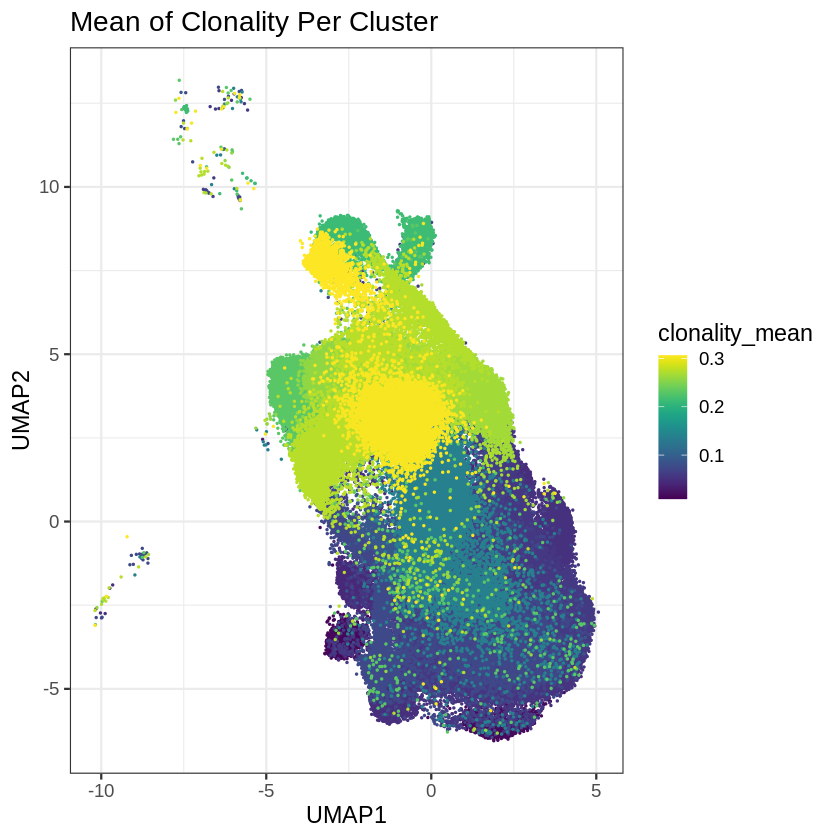

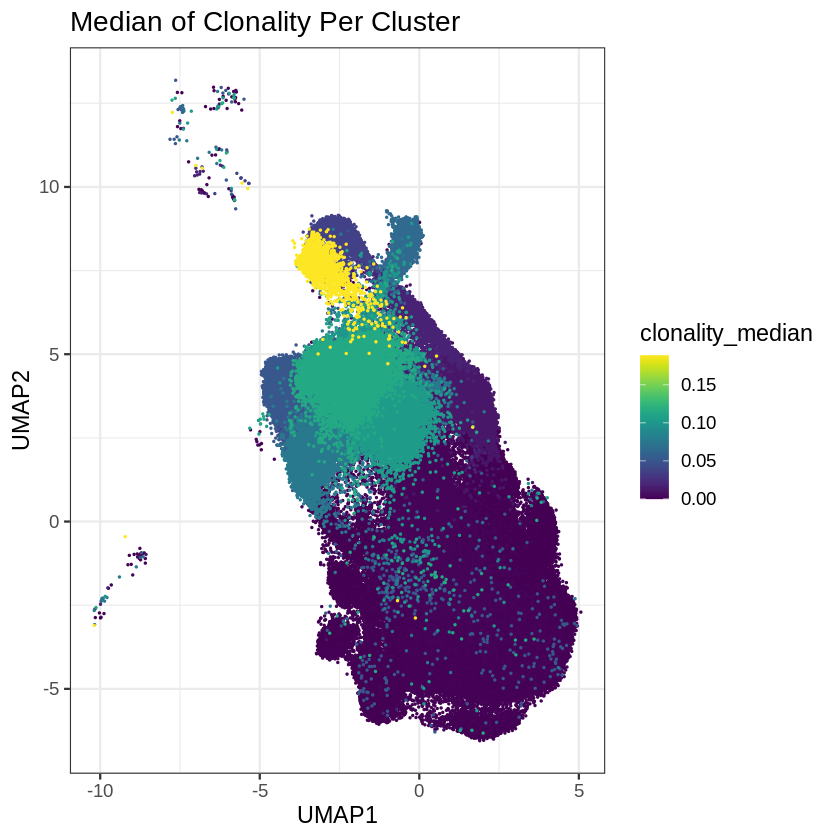

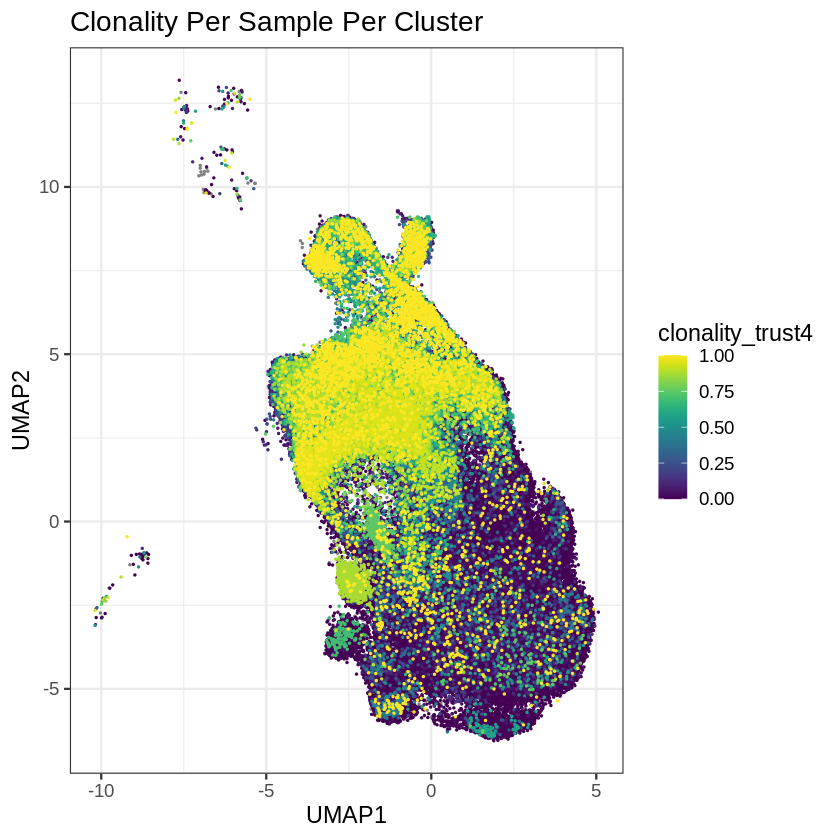

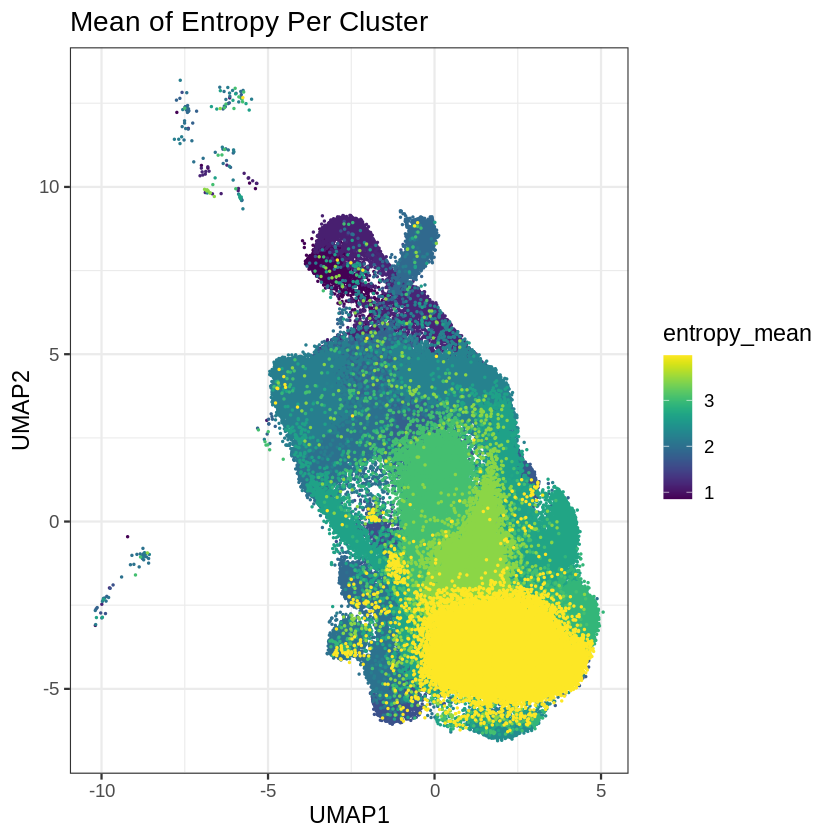

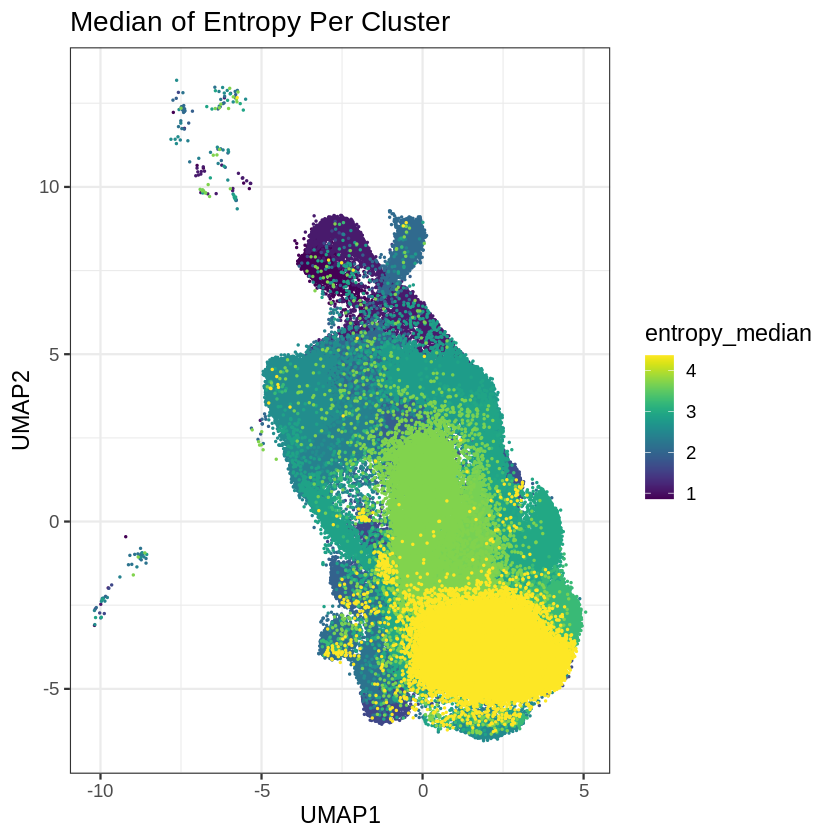

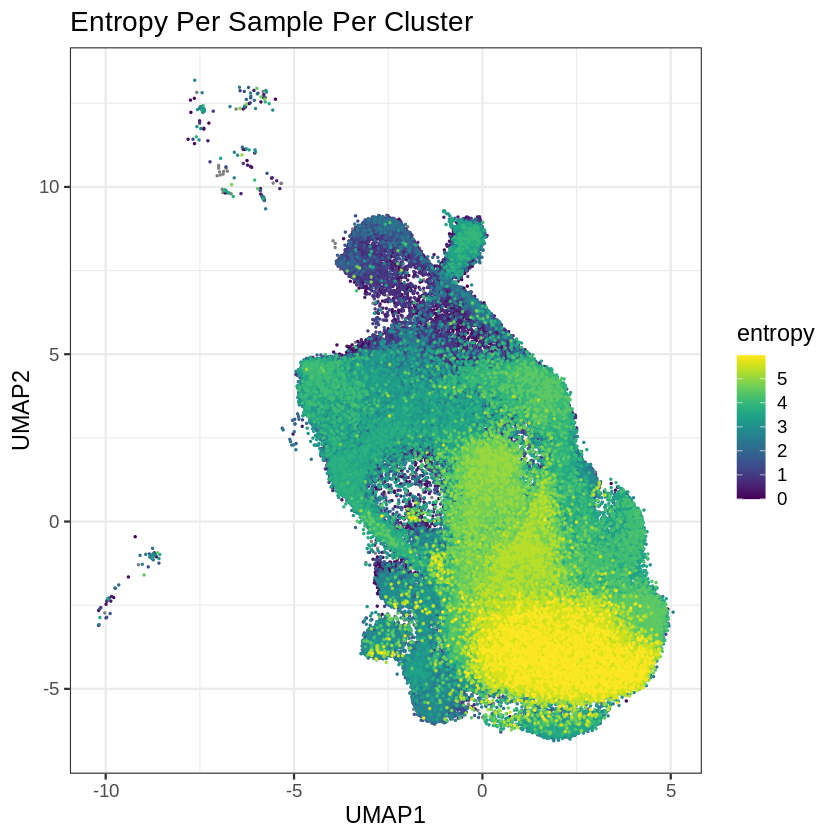

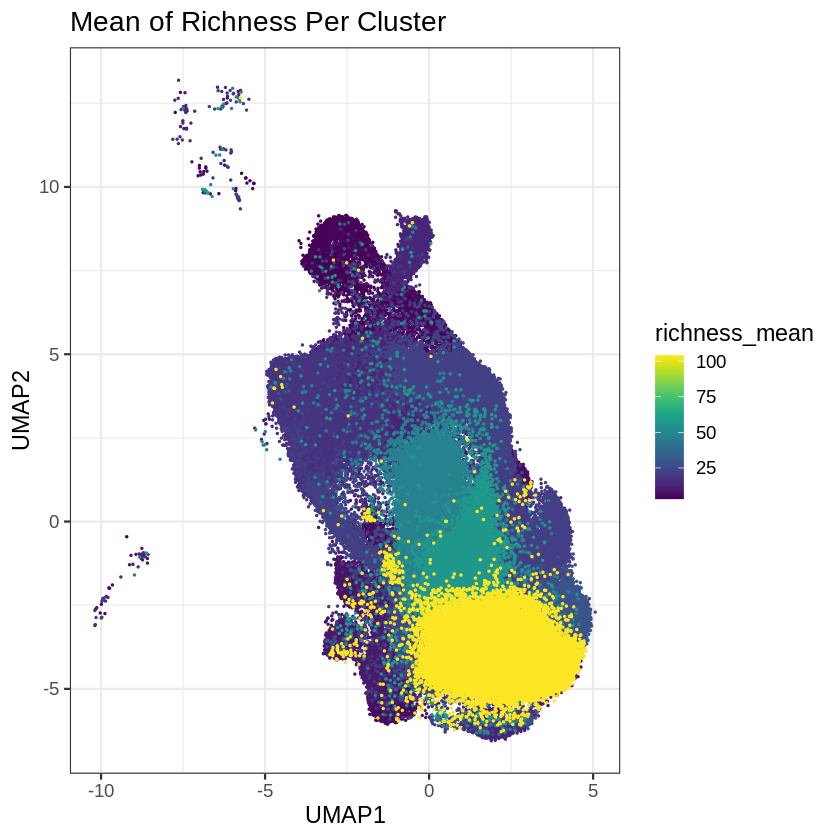

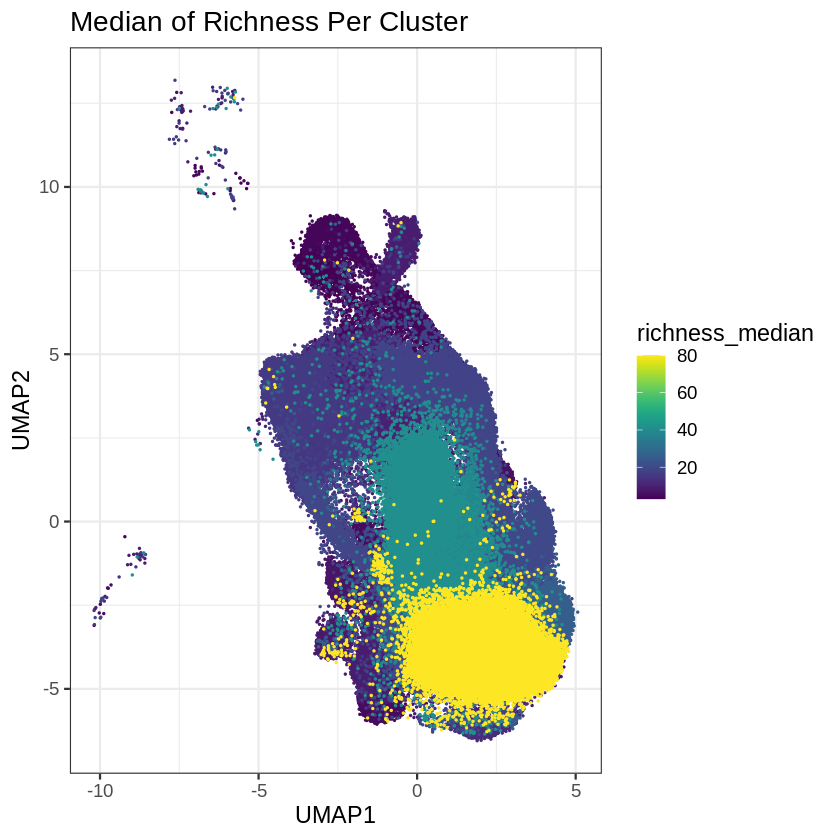

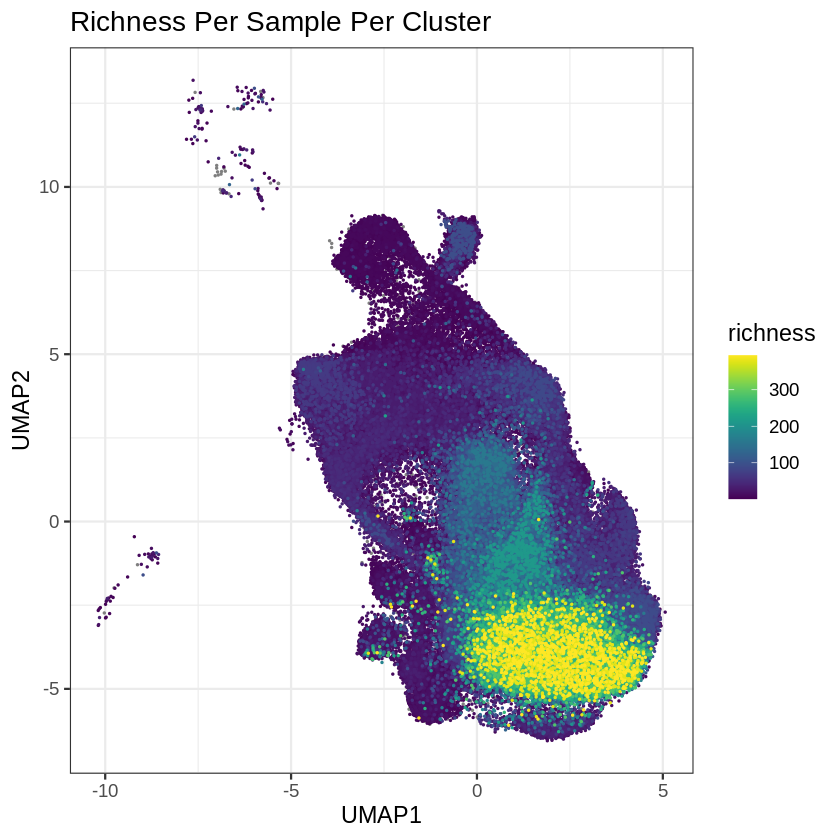

In [188]:
#Clonality
B_cell_trust4 %>%
    mutate(is_na= !is.na(clonality_mean))  %>% 
    arrange(is_na, clonality_mean)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = clonality_mean), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    theme_bw(base_size = 14) +
labs(x = "UMAP1", y = "UMAP2", title = "Mean of Clonality Per Cluster") 

ggsave(here("./results/figures/7_B_cell_clonality_mean_per_cluster.pdf"), width = 9, height =6)

B_cell_trust4 %>%
    mutate(is_na= !is.na(clonality_median))  %>% 
    arrange(is_na, clonality_median)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = clonality_median), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    theme_bw(base_size = 14) +
labs(x = "UMAP1", y = "UMAP2", title = "Median of Clonality Per Cluster") 

ggsave(here("./results/figures/7_B_cell_clonality_median_per_cluster.pdf"), width = 9, height =6)

B_cell_trust4 %>%
    mutate(is_na= !is.na(clonality_trust4))  %>% 
    arrange(is_na, clonality_trust4)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = clonality_trust4), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    theme_bw(base_size = 14) +
labs(x = "UMAP1", y = "UMAP2", title = "Clonality Per Sample Per Cluster") 

ggsave(here("./results/figures/7_B_cell_clonality_per_sample_cluster.pdf"), width = 9, height =6)

#Entropy
B_cell_trust4 %>%
    mutate(is_na= !is.na(entropy_mean))  %>% 
    arrange(is_na, entropy_mean)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = entropy_mean), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    theme_bw(base_size = 14) +
labs(x = "UMAP1", y = "UMAP2", title = "Mean of Entropy Per Cluster") 

ggsave(here("./results/figures/7_B_cell_entropy_mean_per_cluster.pdf"), width = 9, height =6)

B_cell_trust4 %>%
    mutate(is_na= !is.na(entropy_median))  %>% 
    arrange(is_na, entropy_median)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = entropy_median), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    theme_bw(base_size = 14) +
labs(x = "UMAP1", y = "UMAP2", title = "Median of Entropy Per Cluster") 

ggsave(here("./results/figures/7_B_cell_entropy_median_per_cluster.pdf"), width = 9, height =6)

B_cell_trust4 %>%
    mutate(is_na= !is.na(entropy))  %>% 
    arrange(is_na, entropy)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = entropy), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    theme_bw(base_size = 14) +
labs(x = "UMAP1", y = "UMAP2", title = "Entropy Per Sample Per Cluster") 

ggsave(here("./results/figures/7_B_cell_entropy_per_sample_cluster.pdf"), width = 9, height =6)

#richness
B_cell_trust4 %>%
    mutate(is_na= !is.na(richness_mean))  %>% 
    arrange(is_na, richness_mean)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = richness_mean), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    theme_bw(base_size = 14) +
labs(x = "UMAP1", y = "UMAP2", title = "Mean of Richness Per Cluster") 

ggsave(here("./results/figures/7_B_cell_richness_mean_per_cluster.pdf"), width = 9, height =6)

B_cell_trust4 %>%
    mutate(is_na= !is.na(richness_median))  %>% 
    arrange(is_na, richness_median)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = richness_median), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    theme_bw(base_size = 14) +
labs(x = "UMAP1", y = "UMAP2", title = "Median of Richness Per Cluster") 

ggsave(here("./results/figures/7_B_cell_richness_median_per_cluster.pdf"), width = 9, height =6)


B_cell_trust4 %>%
    mutate(is_na= !is.na(richness))  %>% 
    arrange(is_na, richness)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = richness), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    theme_bw(base_size = 14) +
labs(x = "UMAP1", y = "UMAP2", title = "Richness Per Sample Per Cluster") 

ggsave(here("./results/figures/7_B_cell_richness_per_sample_cluster.pdf"), width = 9, height =6)

#### By age or by genotype

In [192]:
# export per sample per cluster into tsv files
clonality_per_sample_per_cluster<- B_cell_trust4  %>% distinct(new_annotation, sample_id, age, genotype, clonality_trust4)
write.table(x = clonality_per_sample_per_cluster, file = './data/B_cell_clonality_per_sample_per_cluster.tsv', quote = FALSE,sep = '\t', row.names = F, col.names = T)

entropy_per_sample_per_cluster<- B_cell_trust4  %>% distinct(new_annotation, sample_id, age, genotype, entropy)
write.table(x = entropy_per_sample_per_cluster, file = './data/B_cell_entropy_per_sample_per_cluster.tsv', quote = FALSE,sep = '\t', row.names = F, col.names = T)

richness_per_sample_per_cluster<- B_cell_trust4  %>% distinct(new_annotation, sample_id, age, genotype, richness)
write.table(x = richness_per_sample_per_cluster, file = './data/B_cell_richness_per_sample_per_cluster.tsv', quote = FALSE,sep = '\t', row.names = F, col.names = T)

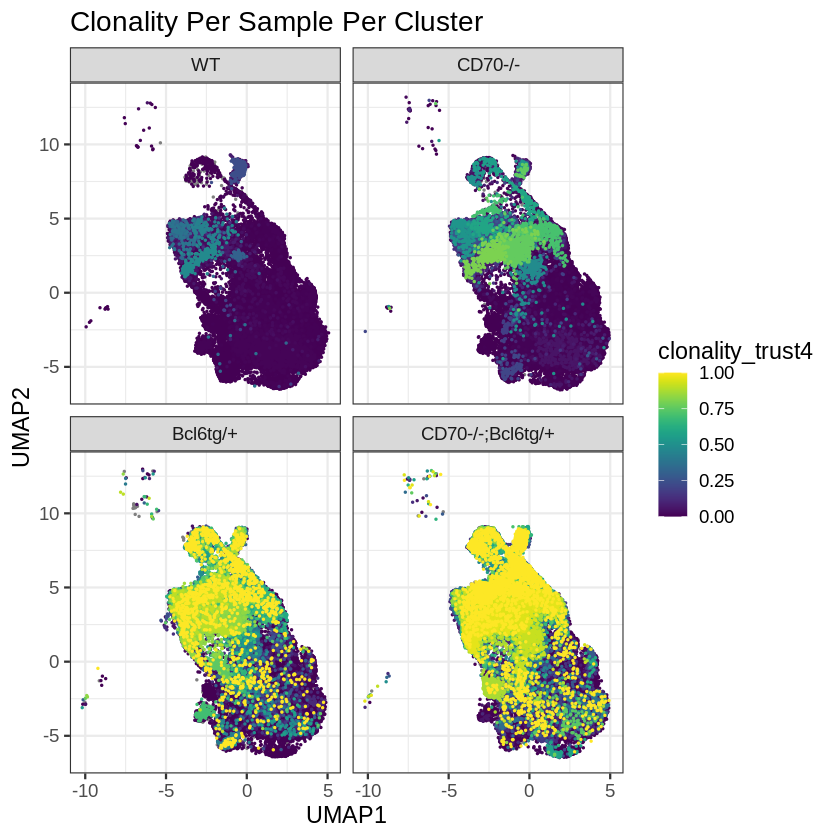

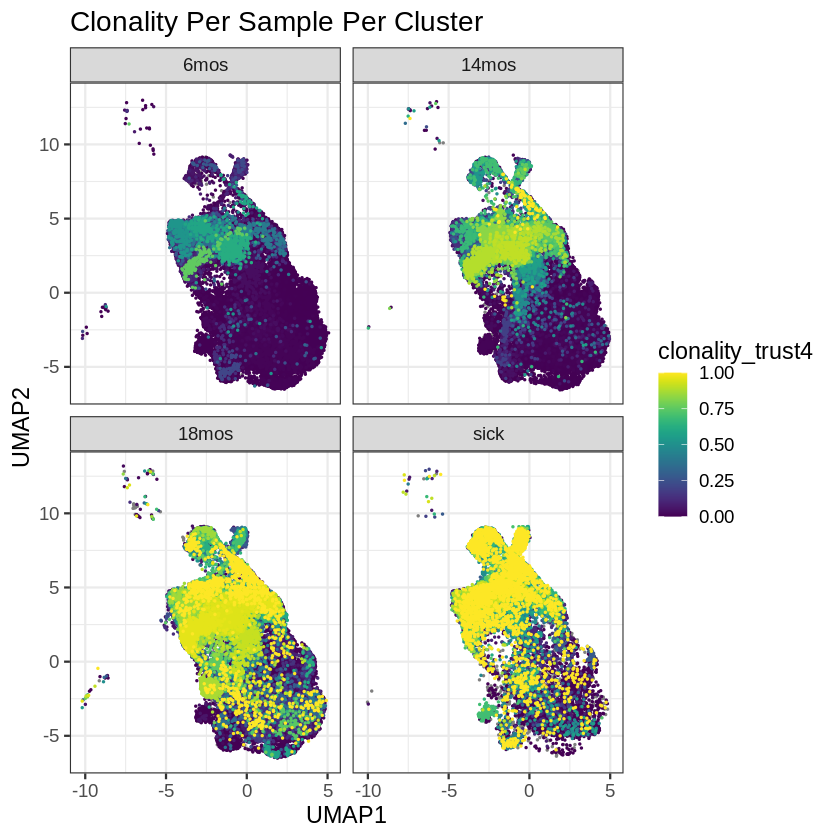

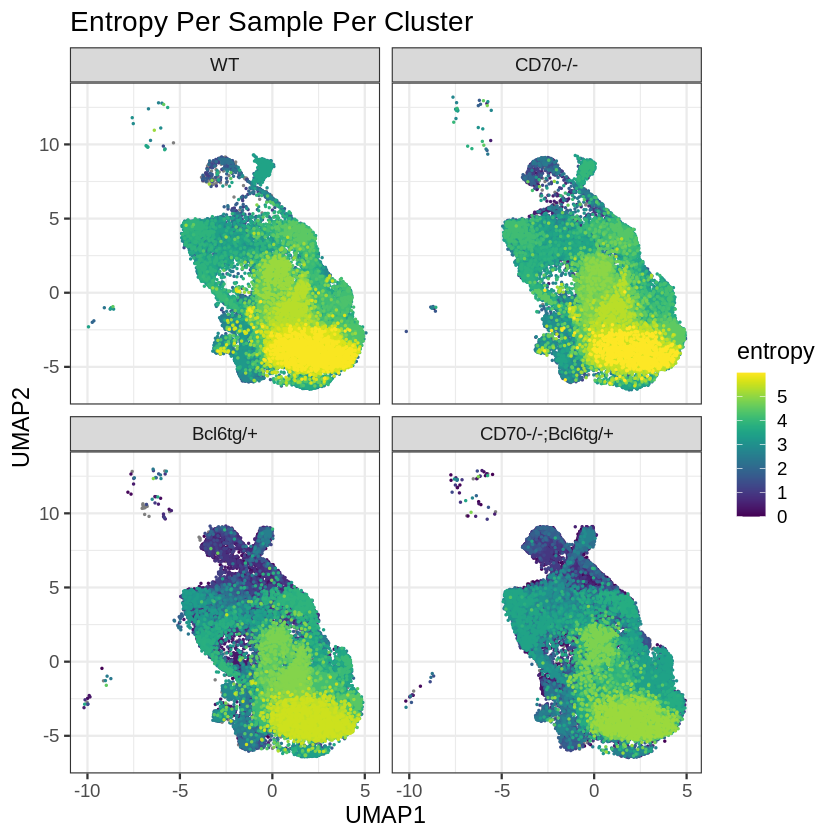

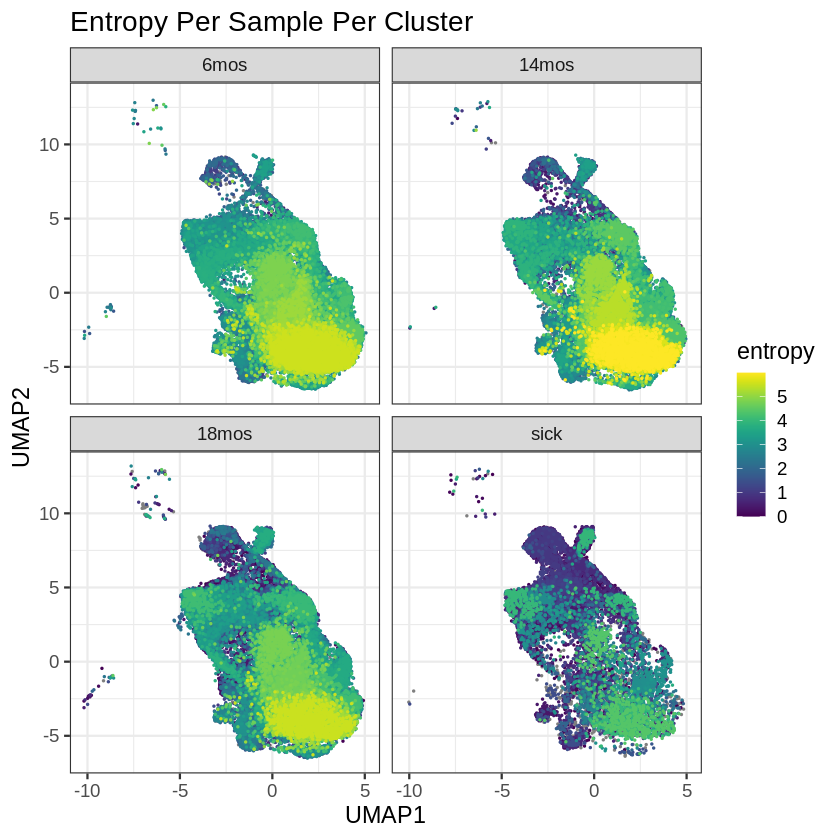

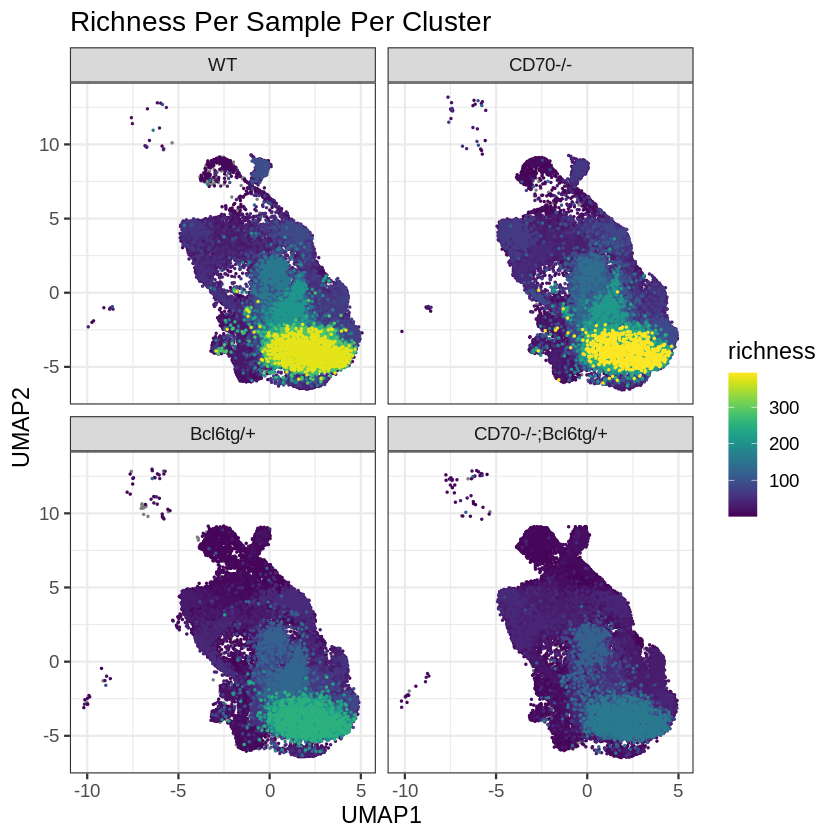

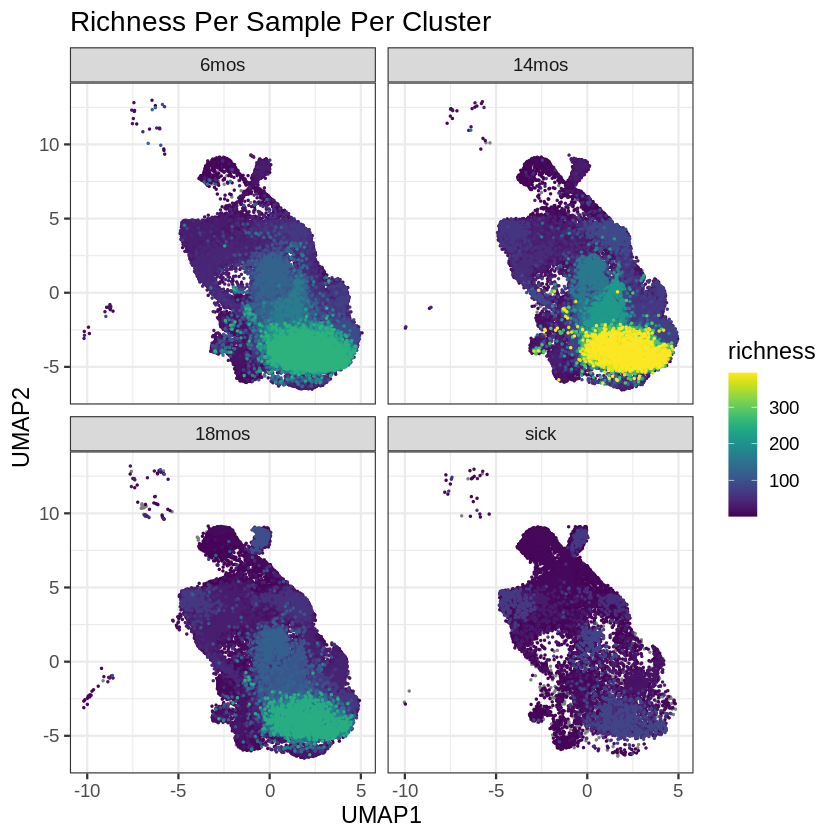

In [189]:
B_cell_trust4 %>%
    mutate(is_na= !is.na(clonality_trust4))  %>% 
    arrange(is_na, clonality_trust4)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))   %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = clonality_trust4), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    facet_wrap(~ genotype, ncol = 2) +
    theme_bw(base_size = 14) +
    labs(x = "UMAP1", y = "UMAP2", title = "Clonality Per Sample Per Cluster") 

ggsave(here("./results/figures/7_B_cell_clonality_per_sample_cluster_by_genotype.pdf"), width = 10, height =8)

B_cell_trust4 %>%
    mutate(is_na= !is.na(clonality_trust4))  %>% 
    arrange(is_na, clonality_trust4)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = clonality_trust4), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    facet_wrap(~ age, ncol = 2) +
    theme_bw(base_size = 14) +
    labs(x = "UMAP1", y = "UMAP2", title = "Clonality Per Sample Per Cluster") 

ggsave(here("./results/figures/7_B_cell_clonality_per_sample_cluster_by_age.pdf"), width = 10, height =8)

B_cell_trust4 %>%
    mutate(is_na= !is.na( entropy))  %>% 
    arrange(is_na, entropy)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = entropy), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    facet_wrap(~ genotype, ncol = 2) +
    theme_bw(base_size = 14) +
    labs(x = "UMAP1", y = "UMAP2", title = "Entropy Per Sample Per Cluster") 

ggsave(here("./results/figures/7_B_cell_entropy_per_sample_cluster_by_genotype.pdf"), width = 10, height =8)

B_cell_trust4 %>%
    mutate(is_na= !is.na( entropy))  %>% 
    arrange(is_na, entropy)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = entropy), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    facet_wrap(~ age, ncol = 2) +
    theme_bw(base_size = 14) +
    labs(x = "UMAP1", y = "UMAP2", title = "Entropy Per Sample Per Cluster") 

ggsave(here("./results/figures/7_B_cell_entropy_per_sample_cluster_by_age.pdf"), width = 10, height =8)

B_cell_trust4 %>%
    mutate(is_na= !is.na(richness))  %>% 
    arrange(is_na, richness)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = richness), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    facet_wrap(~ genotype, ncol = 2) +
    theme_bw(base_size = 14) +
    labs(x = "UMAP1", y = "UMAP2", title = "Richness Per Sample Per Cluster") 

ggsave(here("./results/figures/7_B_cell_richness_per_sample_cluster_by_genotype.pdf"), width = 10, height =8)

B_cell_trust4 %>%
    mutate(is_na= !is.na(richness))  %>% 
    arrange(is_na, richness)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = richness), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    facet_wrap(~ age, ncol = 2) +
    theme_bw(base_size = 14) +
    labs(x = "UMAP1", y = "UMAP2", title = "Richness Per Sample Per Cluster") 

ggsave(here("./results/figures/7_B_cell_richness_per_sample_cluster_by_age.pdf"), width = 10, height =8)

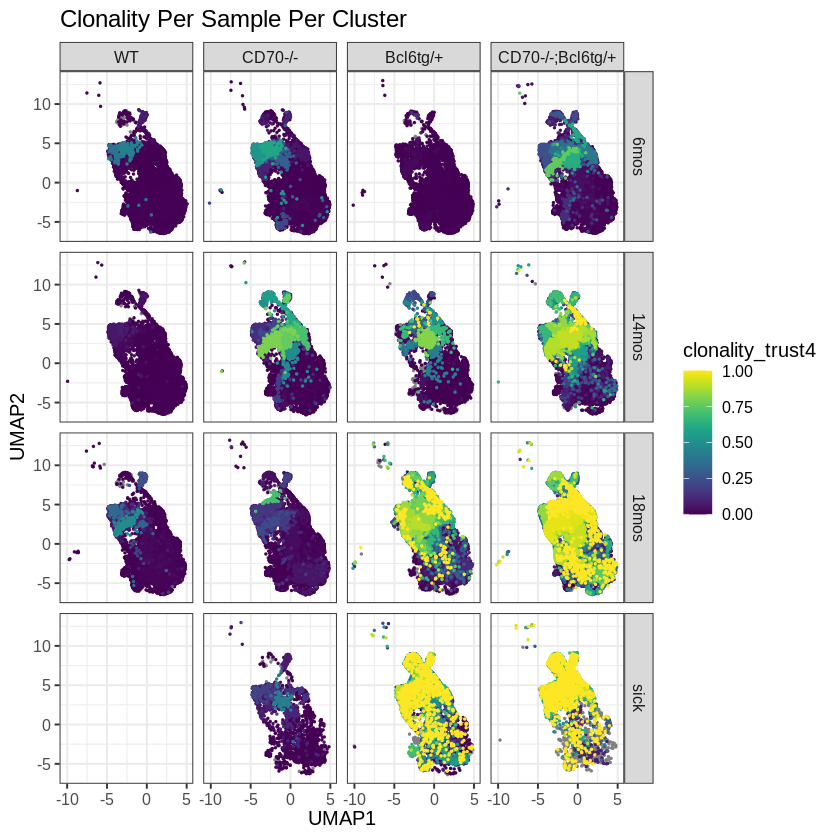

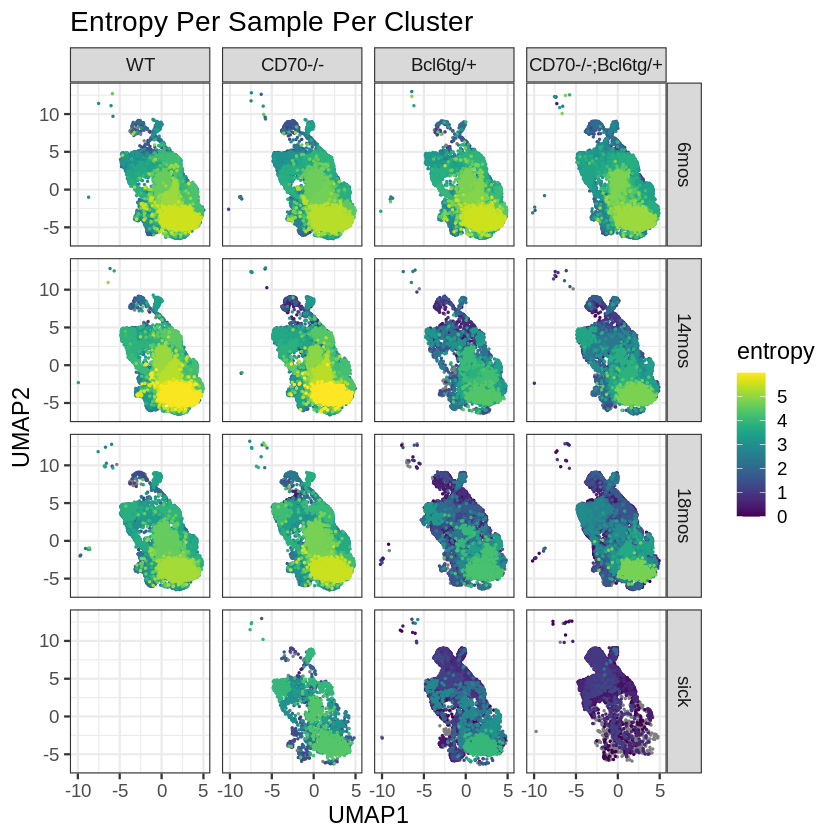

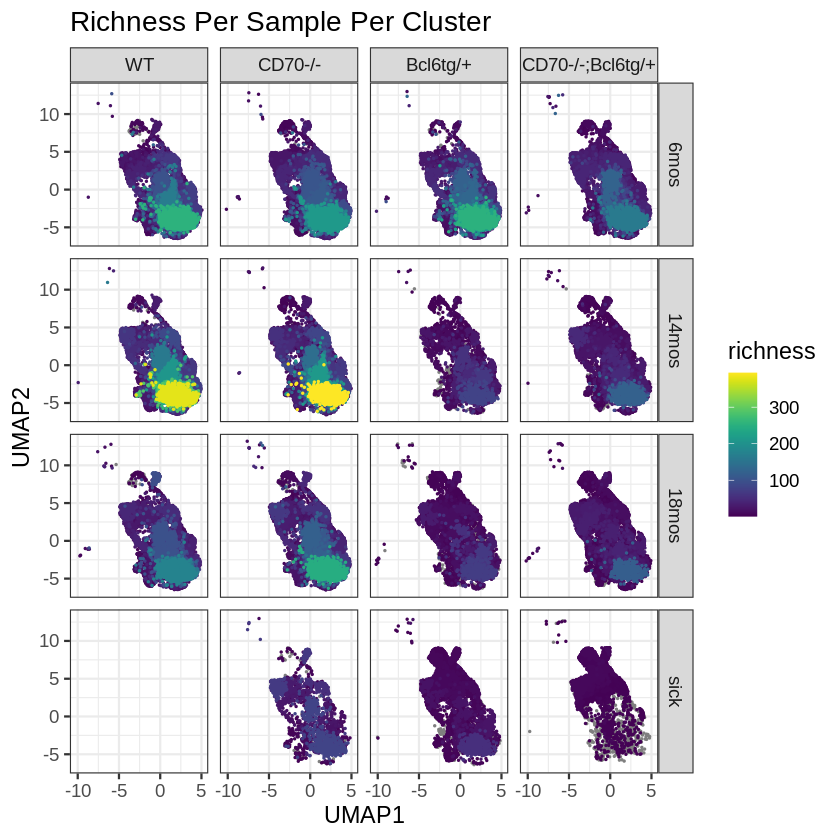

In [190]:
B_cell_trust4 %>%
    mutate(is_na= !is.na(clonality_trust4))  %>% 
    arrange(is_na, clonality_trust4)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = clonality_trust4), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    facet_grid(age ~ genotype) +
    theme_bw(base_size = 12) +
labs(x = "UMAP1", y = "UMAP2", title = "Clonality Per Sample Per Cluster") 

ggsave(here("./results/figures/7_B_cell_clonality_per_sample_cluster_by_age_genotype.pdf"), width = 12, height =10)

B_cell_trust4 %>%
    mutate(is_na= !is.na( entropy))  %>% 
    arrange(is_na, entropy)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = entropy), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    facet_grid(age ~ genotype) +
    theme_bw(base_size = 14) +
labs(x = "UMAP1", y = "UMAP2", title = "Entropy Per Sample Per Cluster") 

ggsave(here("./results/figures/7_B_cell_entropy_per_sample_cluster_by_age_genotype.pdf"), width = 12, height =10)

B_cell_trust4 %>%
    mutate(is_na= !is.na(richness))  %>% 
    arrange(is_na, richness)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = richness), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    facet_grid(age ~ genotype) +
    theme_bw(base_size = 14) +
labs(x = "UMAP1", y = "UMAP2", title = "Richness Per Sample Per Cluster") 

ggsave(here("./results/figures/7_B_cell_richness_per_sample_cluster_by_age_genotype.pdf"), width = 12, height =10)

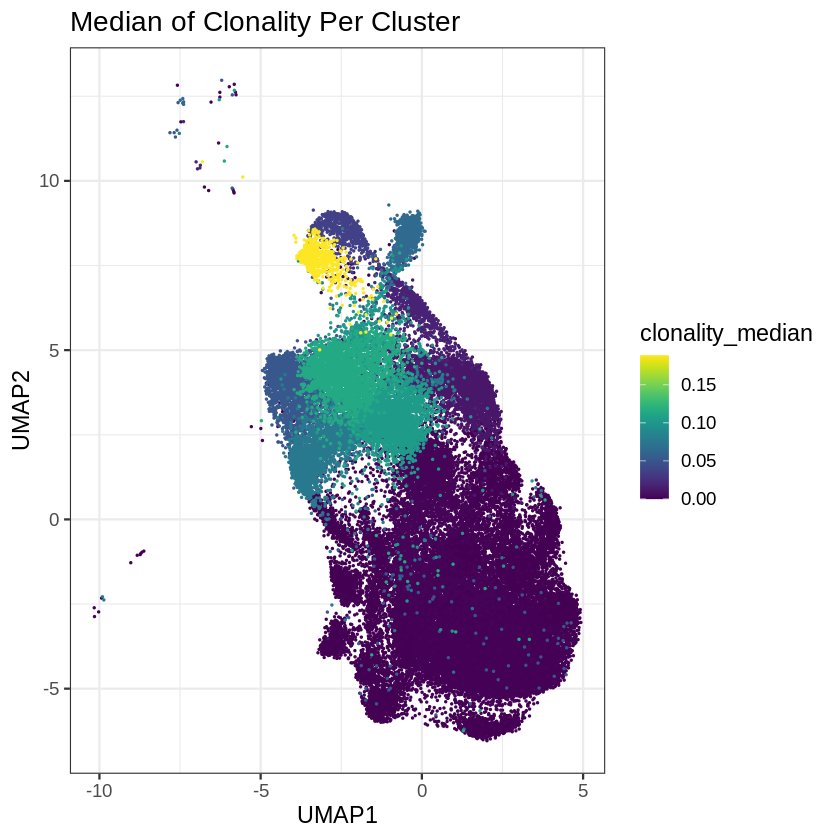

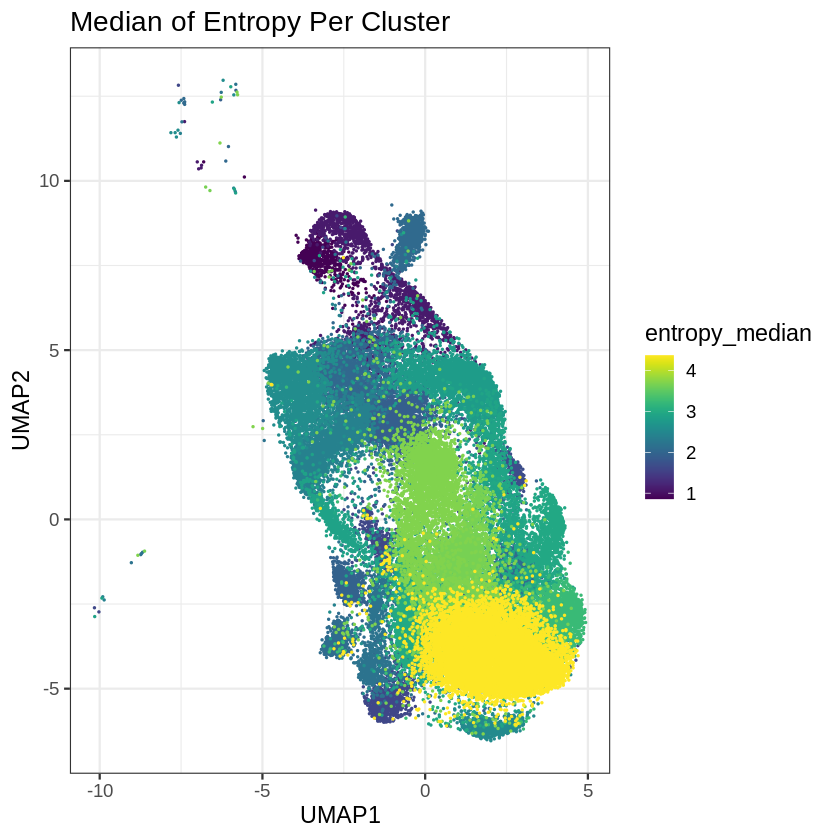

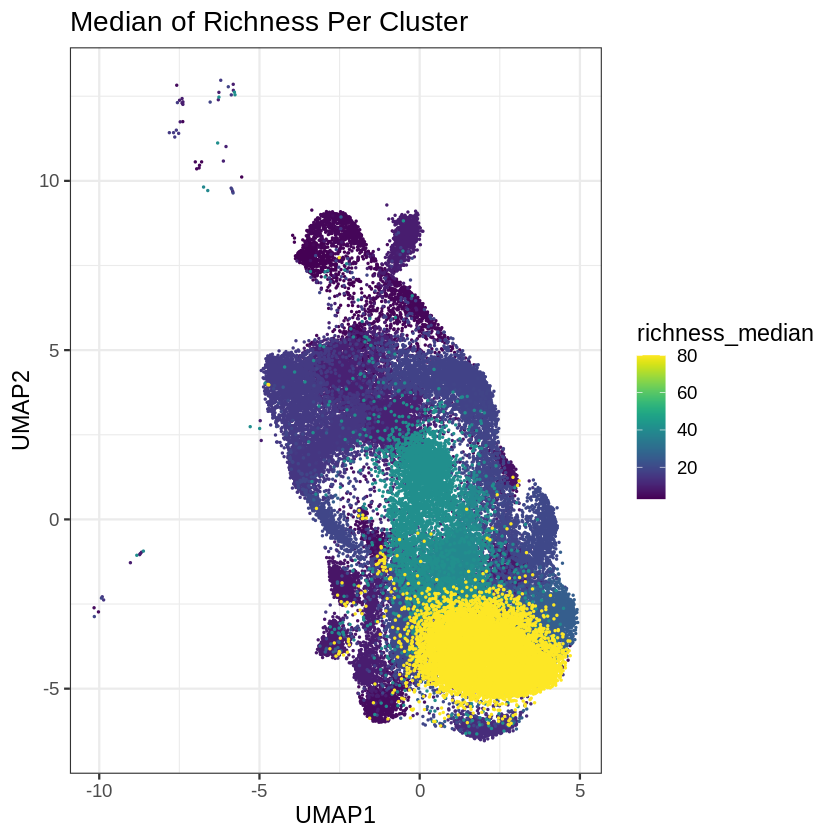

In [191]:
subBarcode = sample(B_cell_trust4$barcode, 50000)
B_cell_trust4_sub<- B_cell_trust4  %>% filter(barcode %in% subBarcode)

B_cell_trust4_sub %>%
    mutate(is_na= !is.na(clonality_median))  %>% 
    arrange(is_na, clonality_median)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = clonality_median), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    theme_bw(base_size = 14) +
labs(x = "UMAP1", y = "UMAP2", title = "Median of Clonality Per Cluster") 

ggsave("./results/figures/7_B_cell_clonality_median_per_cluster_sub50000.pdf", width = 6, height =4)

B_cell_trust4_sub %>%
    mutate(is_na= !is.na(entropy_median))  %>% 
    arrange(is_na, entropy_median)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = entropy_median), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    theme_bw(base_size = 14) +
labs(x = "UMAP1", y = "UMAP2", title = "Median of Entropy Per Cluster") 

ggsave("./results/figures/7_B_cell_entropy_median_per_cluster_sub50000.pdf", width = 6, height =4)

B_cell_trust4_sub %>%
    mutate(is_na= !is.na(richness_median))  %>% 
    arrange(is_na, richness_median)  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>% 
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = richness_median), size = 0.3) +
    scale_color_viridis(discrete = FALSE) +
    theme_bw(base_size = 14) +
labs(x = "UMAP1", y = "UMAP2", title = "Median of Richness Per Cluster") 

ggsave("./results/figures/7_B_cell_richness_median_per_cluster_sub50000.pdf", width = 6, height =4)